In [12]:
from NN.Masks import PolynomialMaskGenerator
input_mask = PolynomialMaskGenerator((256,256), sampling_factor=1./8.,radius=0.04,seed=0xdeadbeef)
np.sum(input_mask.get_mask(None))


5632.0

In [1]:
import tensorflow as tf
import numpy as np
tf.config.set_visible_devices([],'GPU')

In [2]:
def my_ssim(y_true, y_pred):
    #abs
    pred_abs = tf.expand_dims(y_pred[:,:,:,0],axis=3)
    pred_abs = tf.add(pred_abs,tf.constant(1.,dtype=y_true.dtype))
    true_abs = tf.expand_dims(y_true[:,:,:,0],axis=3)
    true_abs = tf.add(true_abs,tf.constant(1.,dtype=y_true.dtype))
    ssim_abs = tf.image.ssim(true_abs,pred_abs,2.)
    #phase
    pred_phase = tf.expand_dims(y_pred[:,:,:,1],axis=3)
    pred_phase = tf.add(pred_phase,tf.constant(np.pi,dtype=y_true.dtype))
    true_phase = tf.expand_dims(y_true[:,:,:,1],axis=3)
    true_phase = tf.add(true_phase,tf.constant(np.pi,dtype=y_true.dtype))
    ssim_phase = tf.image.ssim(true_phase,pred_phase,2*np.pi)
    total_ssim = tf.add(ssim_abs,ssim_phase)
    total_ssim = tf.scalar_mul(-1.,total_ssim)
    total_ssim = tf.add(tf.constant(2.,dtype=y_true.dtype),total_ssim)
    return total_ssim

In [3]:
from NN.Generators import DataGenerator_kspace_to_img, DataGenerator_img
mygen = DataGenerator_kspace_to_img(r'D:\NN_DATA\singlecoil_acc15_absphasekspaceimg_10midslices_kabsmaxnormminless_pointmask\val',batch_size=1)
img_gen = DataGenerator_img(r'D:\NN_DATA\singlecoil_acc15_absphasekspaceimg_10midslices_kabsmaxnormminless_pointmask\val',batch_size=36)


In [9]:
ssims = []
for i, batch in enumerate(img_gen):
    for ssim in my_ssim(batch[0],batch[1]).numpy():
        # print(ssim)
        ssims.append(ssim)
    print('Batch {}/{}'.format(i,len(img_gen)))
print('TOTAL masked raw ssim : {}'.format(sum(ssims)/len(ssims)))

Batch 0/55
Batch 1/55
Batch 2/55
Batch 3/55
Batch 4/55
Batch 5/55
Batch 6/55
Batch 7/55
Batch 8/55
Batch 9/55
Batch 10/55
Batch 11/55
Batch 12/55
Batch 13/55
Batch 14/55
Batch 15/55
Batch 16/55
Batch 17/55
Batch 18/55
Batch 19/55
Batch 20/55
Batch 21/55
Batch 22/55
Batch 23/55
Batch 24/55
Batch 25/55
Batch 26/55
Batch 27/55
Batch 28/55
Batch 29/55
Batch 30/55
Batch 31/55
Batch 32/55
Batch 33/55
Batch 34/55
Batch 35/55
Batch 36/55
Batch 37/55
Batch 38/55
Batch 39/55
Batch 40/55
Batch 41/55
Batch 42/55
Batch 43/55
Batch 44/55
Batch 45/55
Batch 46/55
Batch 47/55
Batch 48/55
Batch 49/55
Batch 50/55
Batch 51/55
Batch 52/55
Batch 53/55
Batch 54/55
TOTAL masked raw ssim : 1.0576580400418754


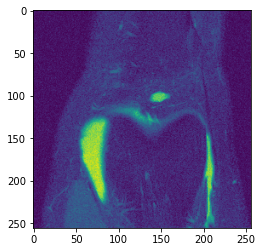

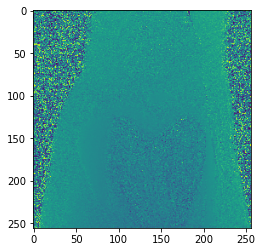

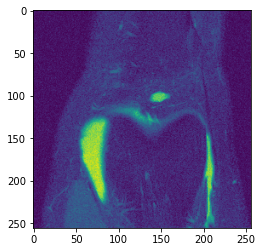

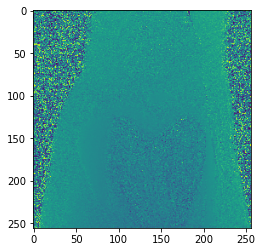

True


In [3]:
import h5py
from utils.fastMRI_utils import ifft
import matplotlib.pyplot as plt
h5f = h5py.File(r'D:\NN_DATA\singlecoil_acc15_absphasekspaceimg_10midslices_kabsmaxnormminless_pointmask\val\file1000000.h5','r')
kspace = h5f['kspace_ground_truth'][0]
image = h5f['image_ground_truth'][0]
plt.imshow(image[:,:,0])
plt.show()
plt.imshow(image[:,:,1])
plt.show()

real = kspace[:,:,0] * np.cos(kspace[:,:,1])
imag = kspace[:,:,0] * np.sin(kspace[:,:,1])
kspace_complex = real + 1j*imag
img_complex = ifft(kspace_complex)
plt.imshow(np.abs(img_complex))
plt.show()
plt.imshow(np.angle(img_complex))
plt.show()
image_from_fft = np.empty((256,256,2),dtype=image.dtype)
image_from_fft[:,:,0] = np.abs(img_complex)
image_from_fft[:,:,1] = np.angle(img_complex)
# image_from_fft[:,:,0] = image_from_fft[:,:,0] - np.amin(image_from_fft[:,:,0])
image_from_fft[:,:,0] = image_from_fft[:,:,0]/np.amax(image_from_fft[:,:,0])
image_from_fft[:,:,0] = (2.*image_from_fft[:,:,0]) - 1.

print(np.all(np.isclose(image,image_from_fft)))
kspace_input = np.reshape(kspace,(1,256,256,2))
image_output = np.reshape(image,(1,256,256,2))

In [5]:
from NN.architectures import double_reconGAN
model = double_reconGAN((256,256,2),16,8,skip=True,kernel_initializer='zeros')
model.compile(loss=my_ssim,optimizer='adam')

In [6]:
outp = model.predict(kspace_input)

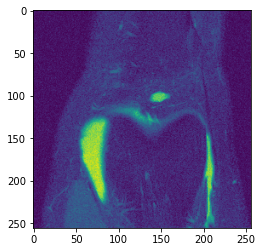

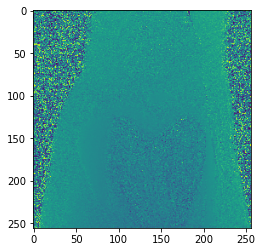

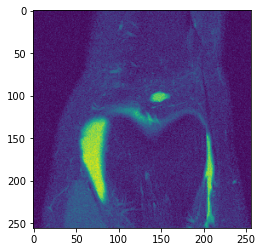

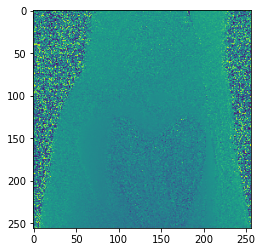

In [7]:
plt.imshow(image_output[0,:,:,0])
plt.show()
plt.imshow(image_output[0,:,:,1])
plt.show()
plt.imshow(outp[0,:,:,0])
plt.show()
plt.imshow(outp[0,:,:,1])
plt.show()

In [8]:
my_ssim(tf.cast(image_output,outp.dtype),outp[:,:,:,:])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [9]:
my_ssim(np.expand_dims(image_from_fft.astype(np.float32),axis=0),np.expand_dims(image.astype(np.float32),axis=0))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [10]:
print(np.sum(np.abs(kspace_complex) == kspace[:,:,0]))
np.abs(kspace_complex).shape
print(256*256)

60083
65536
